In [5]:
# referenced from https://qiita.com/takubb/items/7d45ae701390912c7629
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [6]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 乱数シード固定（再現性の担保）
def fix_seed(seed):
    # random
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#seed = 42
#fix_seed(seed)

# データローダーのサブプロセスの乱数seedが固定
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [7]:
# データセットの作成
import csv

trans = transforms.Compose([
    transforms.ToTensor()
])

STEP0 = 5
STEP1 = 50

class FocusPatchDataset(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, FILE, imsize, psize, channels, n_sample, transforms):
        # load file
        with open(FILE,'rt') as f:
            reader = csv.reader(f)
            data = [row for row in reader]

        self.data = []
        for i in range(len(data)-STEP1):
            if channels == 2:
                self.data.append([float(data[i][1]), data[i][2], data[i+STEP1][2]])
            elif channels == 3:
                self.data.append([float(data[i][1]), data[i][2], data[i+STEP0][2], data[i+STEP1][2]])
            else:
                print('channels is wrong.')
                
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        self.n_sample = n_sample

        self.imsize = imsize
        self.psize = psize
        self.locs = []

        # サンプル対象となる点を設定する
        w = imsize[0]
        h = imsize[1]        
        for i in range(self.n_sample):
            xx = random.randint(0,w-self.psize)
            yy = random.randint(0,h-self.psize)
            self.locs.append([xx,yy])

        print('locations', self.locs)
    
    def __len__(self):
        return len(self.data * self.n_sample)

    def __getitem__(self, index):
        imgs = []

        # n: file (data) index, m: point index
        n = index // self.n_sample
        m = index % self.n_sample

        val = self.data[n][0]

        x = self.locs[m][0]
        y = self.locs[m][1]
        
        img = Image.open(self.data[n][1])
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)

        img = Image.open(self.data[n][2])
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)
        
        out = np.stack(imgs,axis=2)
        #print(out.shape)
        
        return self.transforms(out), val

In [8]:
dataset = FocusPatchDataset("202409191257-data.csv", imsize = [1600,1200], psize=65, channels=2, n_sample=20, transforms = trans)
train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3])

locations [[30, 373], [698, 927], [318, 526], [1226, 424], [1263, 1044], [223, 298], [1382, 618], [606, 1135], [1087, 898], [1284, 110], [913, 398], [40, 385], [444, 436], [632, 707], [0, 411], [754, 8], [208, 3], [710, 283], [740, 1109], [345, 603]]


In [9]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,  # バッチサイズ
                                           shuffle=True,  # データシャッフル
                                           num_workers=0,  # 高速化
                                           pin_memory=True  # 高速化                                      
                                           )
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=0,  # 高速化
                                          pin_memory=True  # 高速化                                                   
                                          )

In [10]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
# model = RESNETLIKE(channels=2).to(device)
model = MyModel(channels=2)
#model = MyModel_shallow(channels=2).to(device)

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    path_saved_model = "./saved_model_Mymodel"
    model.load_state_dict(torch.load(path_saved_model))
    model.eval()

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters())

C:\Users\nakazawa\AppData\Local\Temp\ipykernel_22244\4142534970.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_saved_model))


In [12]:
# モデル訓練関数
def train_model(model, train_loader, test_loader):
    # Train loop ----------------------------
    model.train()  # 学習モードをオン
    train_batch_loss = []
    for data, val in train_loader:
        # GPUへの転送
        data, val = data.to(device), val.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        val = val.unsqueeze(1).to(torch.float32)
        # 3. 誤差計算
        loss = criterion(output, val)
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())

    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for data, val in test_loader:
            data, val = data.to(device), val.to(device)
            output = model(data)
            val = val.unsqueeze(1).to(torch.float32)
            loss = criterion(output, val)
            test_batch_loss.append(loss.item())

    return model, np.mean(train_batch_loss), np.mean(test_batch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 4828.447, Test loss: 3457.464
Train loss: 3178.282, Test loss: 2871.195
Train loss: 2667.879, Test loss: 2479.436
Train loss: 2540.929, Test loss: 2050.406
Train loss: 2088.176, Test loss: 1857.510
Train loss: 2021.319, Test loss: 1852.342
Train loss: 1917.062, Test loss: 1581.147
Train loss: 1668.754, Test loss: 1301.377
Train loss: 1373.780, Test loss: 1131.693
Train loss: 1197.054, Test loss: 1051.934
Train loss: 1048.557, Test loss: 951.193
Train loss: 1009.139, Test loss: 891.392
Train loss: 1012.490, Test loss: 956.173
Train loss: 1019.619, Test loss: 1065.303
Train loss: 1126.876, Test loss: 942.673
Train loss: 996.797, Test loss: 876.278
Train loss: 843.810, Test loss: 721.959
Train loss: 729.384, Test loss: 695.916
Train loss: 728.266, Test loss: 684.618
Train loss: 671.888, Test loss: 665.410
Train loss: 649.134, Test loss: 690.174
Train loss: 618.656, Test loss: 534.858
Train loss: 594.468, Test loss: 611.658
Train loss: 579.231, Test loss: 531.680
Train loss: 50

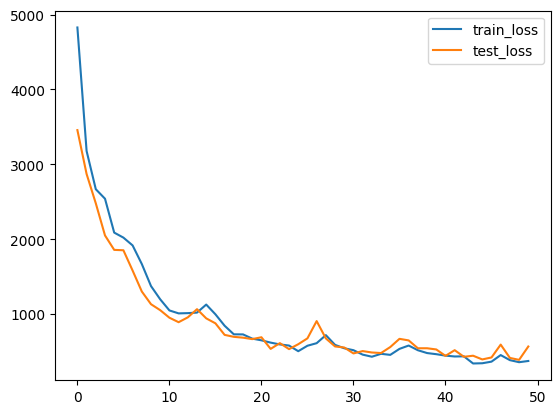

In [13]:
# 訓練の実行
epoch = 50
train_loss = []
test_loss = []

for epoch in tqdm(range(epoch)):
    model, train_l, test_l = train_model(model,train_loader,test_loader)
    train_loss.append(train_l)
    test_loss.append(test_l)    
    # 10エポックごとにロスを表示
    #if epoch % 5 == 0:
    print(f"Train loss: {train_loss[-1]:.3f}, Test loss: {test_loss[-1]:.3f}")

# 学習状況（ロス）の確認
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()

In [14]:
# 学習済みモデルの保存・ロード
path_saved_model = "./saved_model_Mymodel"
# モデルの保存
torch.save(model.state_dict(), path_saved_model)

In [34]:
# 学習済みモデルから予測結果と正解値を取得
def retrieve_result(model, dataloader):
    model.eval()
    preds = []
    labels = []
    # Retreive prediction and labels
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            # Collect data
            preds.append(output)
            labels.append(label)
    # Flatten
    preds = torch.cat(preds, axis=0)
    labels = torch.cat(labels, axis=0)
    # Returns as numpy (CPU環境の場合は不要)
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return preds, labels


# データを作って評価してみる
dataset = FocusPatchDataset("202409191257-data.csv", imsize = [1600,1200], psize=65, channels=2, n_sample=1, transforms = trans)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
preds, labels = retrieve_result(model, test_loader)

locations [[693, 882]]


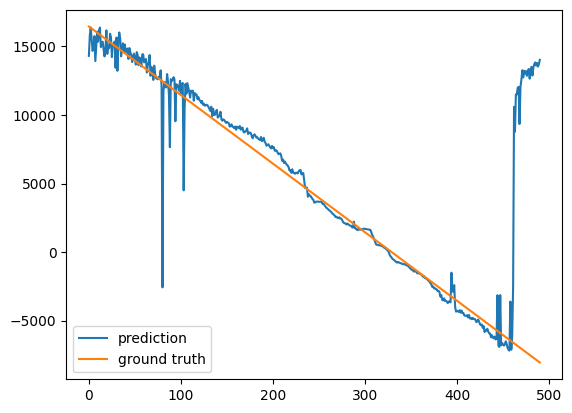

In [35]:
#for x,y in zip(preds,labels):
#    print(x,y,abs(x-y))
plt.plot(preds, label="prediction")
plt.plot(labels, label='ground truth')
plt.legend()